In [122]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, r2_score

from pandas.plotting import autocorrelation_plot

In [39]:
data = pd.read_csv('w1-cali.csv')
date = data['date']
data.drop(['date'], axis=1, inplace=True)

In [52]:
w1 = pd.concat([date, data], axis=1)
w1['date'] = pd.to_datetime(w1['date'])
w1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 8 columns):
date       1020 non-null datetime64[ns]
whfp       1020 non-null float64
whft       1020 non-null float64
bhp        1020 non-null float64
gl_rate    1020 non-null int64
gor        1020 non-null int64
wct        1020 non-null float64
q_oil      1020 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 63.8 KB


In [85]:
need = w1[['date', 'whfp', 'whft', 'bhp', 'wct']]

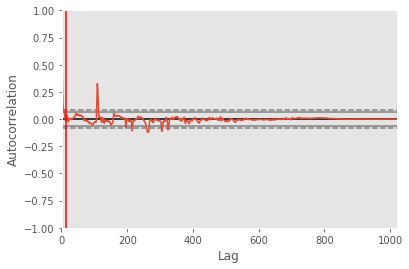

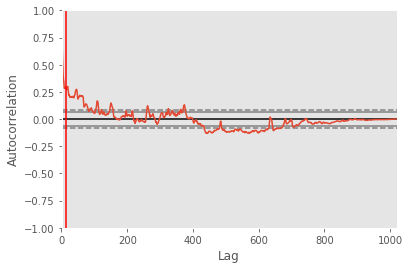

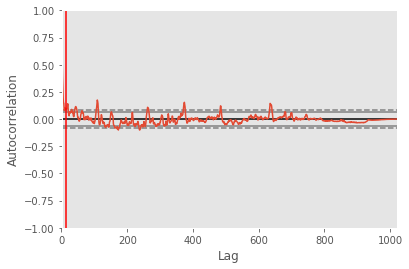

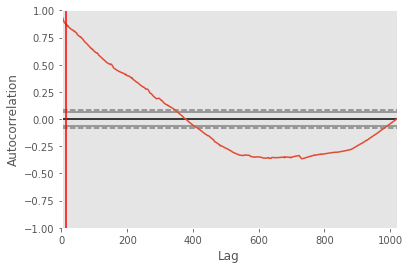

In [92]:
for col in ['whfp', 'whft', 'bhp', 'wct']:
    ax = autocorrelation_plot(need[col])
    ax.axvline(15, c='r', linewidth=1.5)
    plt.show()

In [61]:
bhp = w1['bhp']

In [163]:
train, test = bhp[900:-14], bhp[-14:]

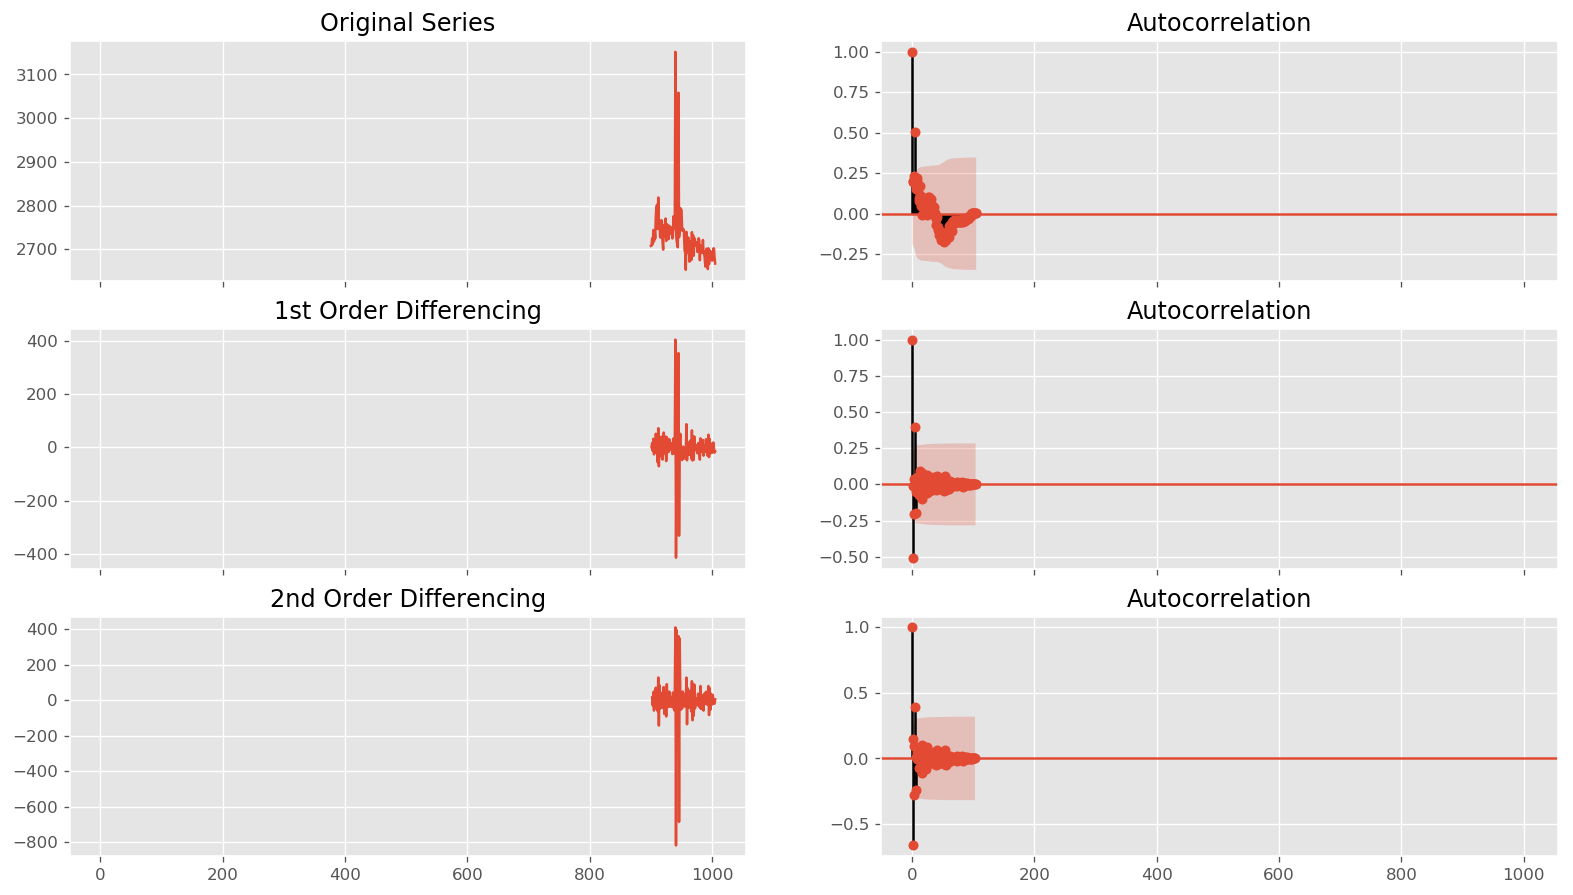

In [164]:
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train); axes[0, 0].set_title('Original Series')
plot_acf(train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.diff().diff().dropna(), ax=axes[2, 1])

plt.rcParams.update({'figure.figsize':(16,9), 'figure.dpi':120})
plt.show()

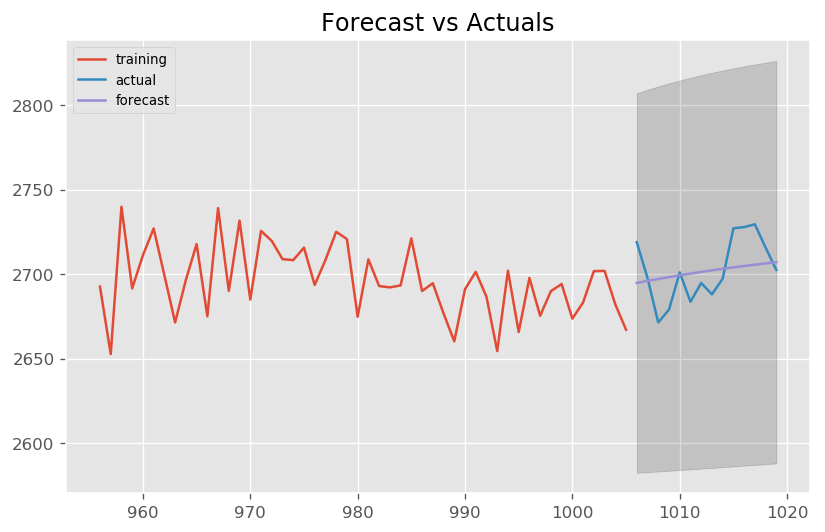

In [168]:
order=(1, 0, 1)

model  = ARIMA(train, order=order)
fitted = model.fit(disp=0)

fc, se, conf = fitted.forecast(14, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train[-50:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [169]:
print(fitted.summary())

                              ARMA Model Results                              
Dep. Variable:                    bhp   No. Observations:                  106
Model:                     ARMA(1, 1)   Log Likelihood                -579.617
Method:                       css-mle   S.D. of innovations             57.221
Date:                Tue, 28 May 2019   AIC                           1167.234
Time:                        20:58:18   BIC                           1177.888
Sample:                             0   HQIC                          1171.552
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2723.2142     19.196    141.861      0.000    2685.590    2760.839
ar.L1.bhp      0.9574      0.039     24.478      0.000       0.881       1.034
ma.L1.bhp     -0.8335      0.070    -11.947      0.0

In [170]:
np.sqrt(mean_squared_error(test, fc_series))

16.719579726717512

In [171]:
np.corrcoef(test, fc_series)[0,1]

0.46979211032597745

In [172]:
np.mean(np.abs(fc_series - test)/np.abs(test))

0.005269962709759572